<a href="https://colab.research.google.com/github/khummie97/Multivariate-Wind-turbine-power-curve-modeling/blob/main/Multivariate_Wind_Turbine_Power_Curve_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wind Turbine Power Curves

Wind power curves play important roles in wind power forecasting, wind turbine condition monitoring, estimation of wind energy potential and wind turbine selection. In practice, it is a challenging task to produce reliable wind power curves from raw wind data due to the presence of outliers formed in unexpected conditions, e.g., wind curtailment and blade damage. This Notebook tried to approaching a model for power curve modeling. Moreover, the performances of different ML models are studied.

In general, there are three factors that affect the final wind power curves: data filtering approaches; wind power curve models; and choice of optimization strategies. However, there is no guarantee that all outliers will be removed from the raw wind data. Consequently, designing robust regression models or constructing robust objective functions may be two effective ways to obtain accurate power curves in the presence of outliers.

In [15]:
# # To upload dataset one

import pandas as pd
#https://drive.google.com/file/d/1c6B3ubWX5WPdw2sLtwGI5uDQtEuN4SHe/view?usp=share_link
!gdown --id 1c6B3ubWX5WPdw2sLtwGI5uDQtEuN4SHe
data = pd.read_csv('T1.csv')

# # To upload dataset two

# import pandas as pd
# #https://drive.google.com/file/d/1ZMTG6hz_F0fAqWJ1zDNuWo8QycN7QJnb/view?usp=share_link
# !gdown --id 1ZMTG6hz_F0fAqWJ1zDNuWo8QycN7QJnb
# data = pd.read_csv('Turbine_Data (2).csv')

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1c6B3ubWX5WPdw2sLtwGI5uDQtEuN4SHe
To: /content/T1.csv
100% 3.97M/3.97M [00:00<00:00, 69.4MB/s]


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")


from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
import math


data = data
Truth=pd.DataFrame()
Truth=data
Truth.shape
Truth.describe()


,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


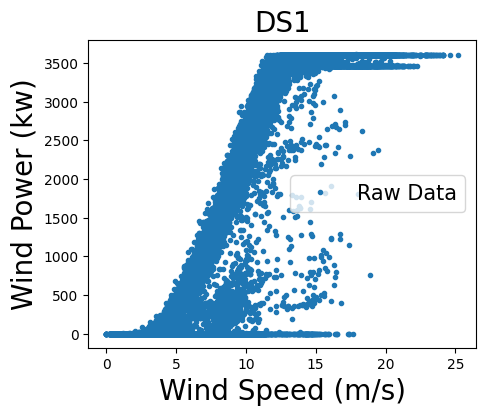

In [3]:

                                  #WIND SPEED VS WIND POWER

Act = data['LV ActivePower (kW)']
Theo = data['Theoretical_Power_Curve (KWh)']
plt.figure(figsize=(5,4))
plt.plot(data['Wind Speed (m/s)'], data['LV ActivePower (kW)'], '.', label='Raw Data',)
#plt.plot(data['Wind Speed (m/s)'], data['Theoretical_Power_Curve (KWh)'], '.', label='theoretical_power_curve (kwh)')
plt.xlabel('Wind Speed (m/s)', size=20)
plt.ylabel('Wind Power (kw)', size=20)
plt.title('DS1' , size=20)
plt.legend(fontsize=15)
plt.show()


# Data preprocessing

In this Notebook, a two-step method to refine the raw power data was used.

First, wind speed data were divided into many small independent intervals, in which outlier data was checked, detected and removed.
Then, the wind power data were further refined according to a histogram with ten bins.

Although multiple data preprocessing methods are employed to process raw wind date, we cannot guarantee that all abnormal points are detected and processed, and there are still many abnormal samples in our processed data. This fact has been illustrated in several publications. Although most of outliers are eliminated, the preprocessed data also have an impact on power curve modeling. There are still several challenges to achieve relatively accurate power curves.

There are in total of 73 DataFrames


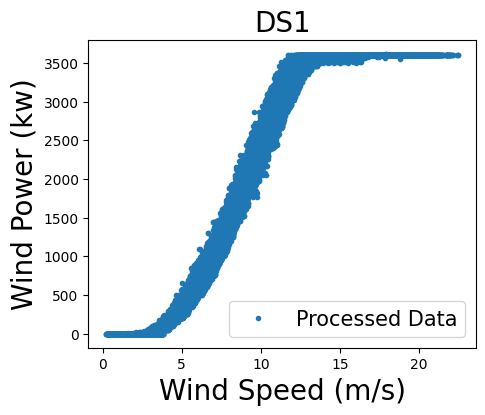

47940


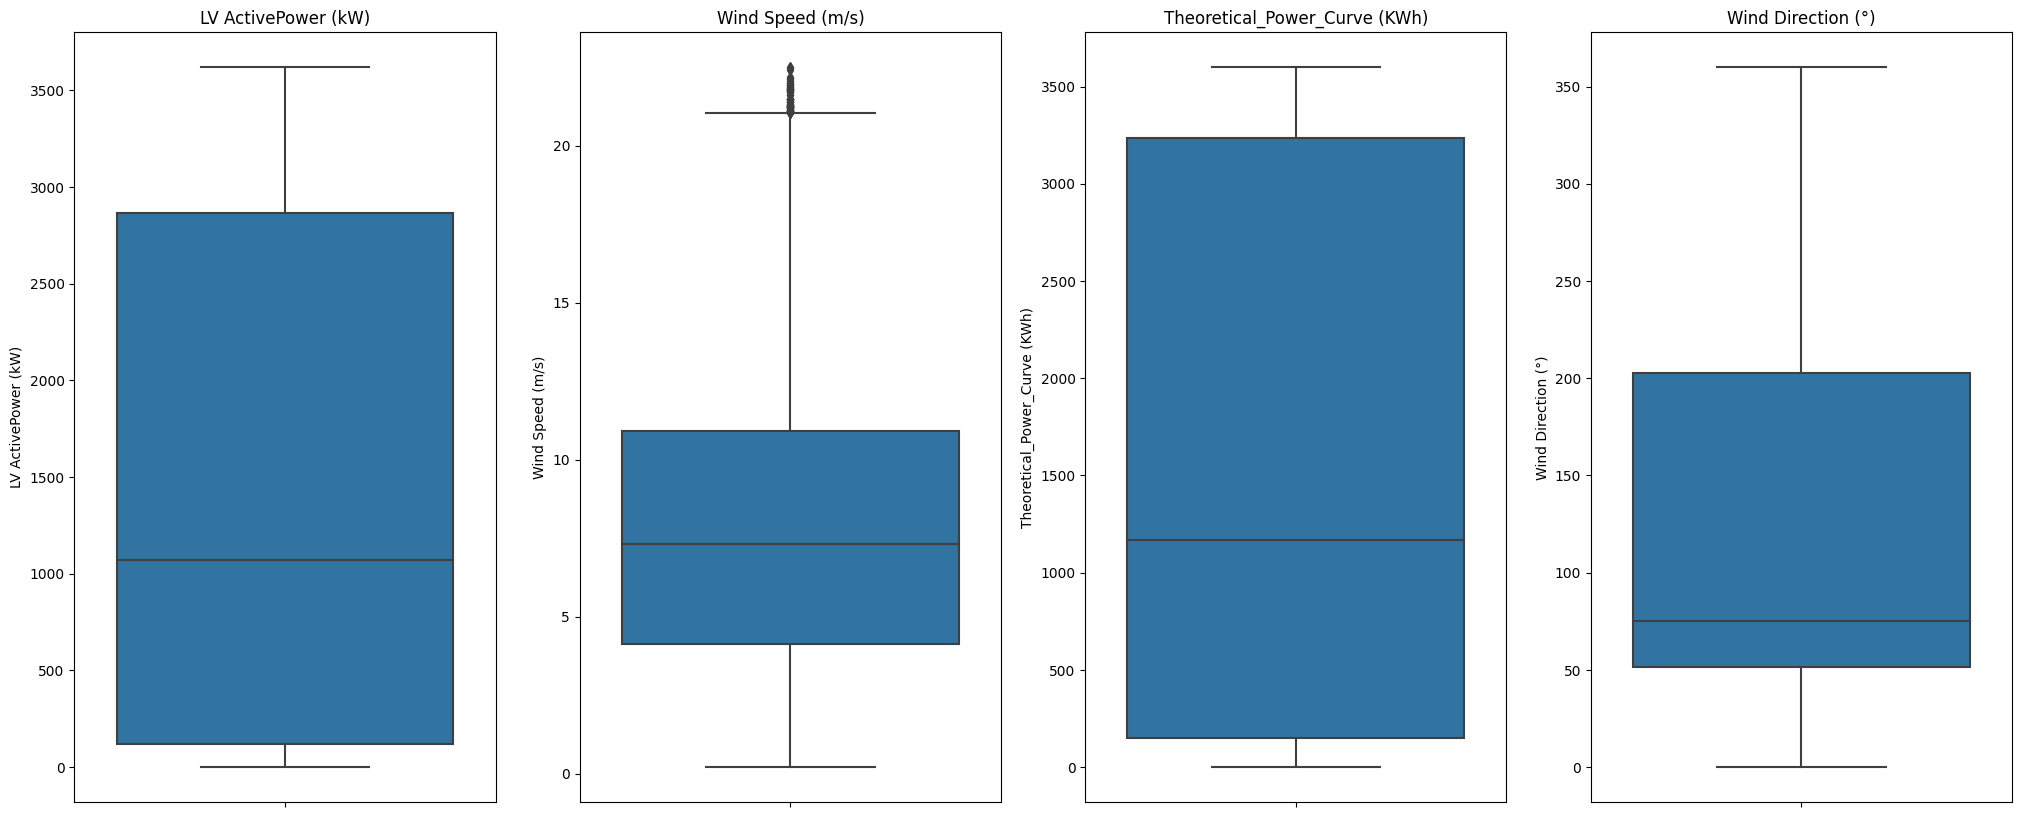

In [4]:
                              # WIND SPEED BASED PRE-PROCESSING

d = {}
step = 50
i = 1
for x in range(0, 3618, step):
    d[i] = data.iloc[((data['LV ActivePower (kW)']>=x)&((data['LV ActivePower (kW)']<x+step))).values]
    #print(d[i])
    i = i + 1
    #print('this is frame no:',i)

print("There are in total of {} DataFrames".format(i-1))

d[74] = data.iloc[(data['LV ActivePower (kW)']>=3600).values]
#print(d[69])

def outlier_remover(dat, prop, min, max):
    d = dat

    #print('the d is  \n', d)
    #print('\n the d[prop] is  \n', d[prop])

    q_low = d[prop].quantile(min)
    #print('\n the q-low is \n',q_low)

    q_hi  = d[prop].quantile(max)
    #print('\n the q-hi is \n',q_hi)

    return d[(d[prop] < q_hi) & (d[prop] > q_low)]



# Remove outlier
for x in range(1, 75):
    if x == 1:          #0-50kw
        F = 0.83
    elif ((x > 1) and (x <= 6)):  #50-300kw
        F = 0.91
    elif ((x > 6) and (x <= 10)):  #300-500kw
        F = 0.8
    elif ((x > 10) and (x <= 20)):  #500-1000kw
        F = 0.92
    elif ((x > 20) and (x <= 30)):   #1000 - 1500kw
        F = 0.96
    elif ((x > 30) and (x <= 35)):   #1500 - 1750kw
        F = 0.96
    elif ((x > 35) and (x <= 40)):   #1750 - 2000kw
        F = 0.97
    elif ((x > 40) and (x <= 45)):   #2000 - 2250kw
        F = 0.96
    elif ((x > 45) and (x <= 50)):   #2250 - 2500kw
        F = 0.95
    elif ((x > 50) and (x <= 55)):   #2500 - 2750kw
        F = 0.97
    elif ((x > 55) and (x <= 60)):   # 2750 - 3000
        F = 0.96
    elif ((x > 60) and (x <= 65)):   # 3000 - 3250
        F = 0.95
    elif ((x > 65) and (x <= 67)):   # 3250 - 3350
        F = 0.95
    elif ((x > 67) and (x <= 68)):   # 3350 - 3400
        F = 0.92
    elif ((x > 68) and (x <= 69)):   # 3400 - 3450
        F = 0.9
    elif ((x > 69) and (x <= 70)):   # 3450 - 3500 #
        F = 0.41
    elif ((x > 70) and (x <= 71)):   # 3500 - 3550
        F = 0.98
    elif ((x > 72) and (x <= 73)):   # 3550 - 3600
        F = 0.98
    else:
        F = 0.985

    d[x] = outlier_remover(d[x], 'Wind Speed (m/s)', 0.0001, F)


    df=pd.DataFrame()
for infile in range(1,75):
    data1 = d[infile]
    df=df.append(data1,ignore_index=True) #all dataframes gets appended one by one in same sequence
    #print('\nthe d[infile] is\n',d[infile])


data2 = df  # processed

ActPower = data2['LV ActivePower (kW)']
theoPower = data2['Theoretical_Power_Curve (KWh)']

plt.figure(figsize=(5,4))
plt.plot(data2['Wind Speed (m/s)'], data2['LV ActivePower (kW)'], '.', label='Processed Data')
plt.xlabel('Wind Speed (m/s)', size=20)
plt.ylabel('Wind Power (kw)', size=20)
plt.title('DS1' , size=20)
plt.legend(fontsize=15)
plt.show()

import matplotlib.pyplot as plt
columns = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
i=1
plt.figure(figsize=(25,10))
for each in columns:
    plt.subplot(1,4,i)
    sns.boxplot(data = df, y= each)
    plt.title(each)
    i += 1


print(len(data2['Wind Direction (°)']))
dff=df

In [5]:
ftrain = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Wind Direction (°)']


#                         # Multivariate MODEL WHICH HAS WIND SPEED AND DIRECTION AS INPUTS (2)
# def Definedata():
#     # define dataset
#     #data3 = df[ftrain]  #with pre-processing of only speed
#     data3 = dff[ftrain]    ##with pre-processing of only speed + direction
#     X = data3.drop(columns=['LV ActivePower (kW)']).values #X dont have ActivePower column as it gets dropped
#     y = data3['LV ActivePower (kW)'].values                #y only contain Active Power column

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 25)
#     return X, y, X_train, X_test, y_train, y_test


                        # Univariate MODEL WHICH HAS ONLY WIND SPEED AS INPUTS (1)
def Definedata():
   # define dataset
   data3 = dff[ftrain]
   X = data3['Wind Speed (m/s)'].values
   y = data3['LV ActivePower (kW)'].values                #y only contain Active Power column
   X = X.reshape(-1,1) #fit function checks that X must have two dimentions, in this case we must make it 2D

   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 25)
    #test_size : If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
    #train_size: If None,the value is automatically set to the complement of the test size.
    #random_state:  is used for initializing the internal random number generator, which will decide the splitting of data into train and test indices in your case. ... Setting random_state a fixed value will guarantee that the same sequence of random numbers is generated each time you run the code.

   return X, y, X_train, X_test, y_train, y_test


###################################################################################################
def Models(models):

    model = models
    X, y, X_train, X_test, y_train, y_test = Definedata()

    #Start Training
    from time import time
    start = time()
    model.fit(X_train,y_train)
    print("This Model took %.4f seconds for training" % ((time() - start)))

    y_pred = model.predict(X_test)
    y_total = model.predict(X)


# ERROR = PREDICTED POWER - ACTIVE POWER
    from scipy.stats import skew
    import numpy
    from sklearn.preprocessing import MinMaxScaler

    length = len(y_pred)
    er = pd.DataFrame()

    for i in range(0,length):
      error_2 = [y_pred[i]-y_test[i]]
      er = er.append(error_2,ignore_index=True)
      #print(er)
    E=er.values
    E=sorted(E)
    E = numpy.array(E)

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(E)
    nE = scaler.transform(E)
    Emean = np.mean(nE)
    Estd = np.std(nE)
    Epdf = stats.norm.pdf(nE, Emean, Estd)

    from scipy.stats import kurtosis, skew
    print("\n Skewness value E is:   ",skew(nE, bias=False))
    print("\n kurtosis value E is:   ",kurtosis(nE, bias=False))

    #LPALACE Distribution
    ag,bg = stats.laplace.fit(nE)
    pdf_laplace = stats.laplace.pdf(nE, ag, bg)

    plt.figure(figsize=(6,5))
    plt.plot(nE, Epdf ,label="Normal") # including h here is crucial
    plt.plot(nE, pdf_laplace, label="Laplace")
    # plt.plot((absE))
    plt.hist(nE, bins=40, density=True, alpha=0.6)

    plt.rc('xtick',labelsize=15)
    plt.rc('ytick',labelsize=15)
    plt.xlabel('Error', size=22)
    plt.ylabel('Distribution', size=22)
    plt.title('Error Distribution (DS1)', size=22)
    plt.legend(fontsize=14)
    plt.grid(False)
    plt.show()

    from sklearn.metrics import accuracy_score

    print("\t\tError Table")
    print('Mean Absolute Error      : ', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared  Error      : ', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared  Error : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Accuracy on Training set   : ', model.score(X_train,y_train))
    print('Accuracy on Testing set  : ', model.score(X_test,y_test))
    r_square = metrics.r2_score(y_test, y_pred)
    print('R-Square Error :', r_square)

    return y_total, y
#########################################################################################################

def Graph_prediction(y_actual, y_predicted):
    y = y_actual
    y_total = y_predicted

    TP = dff['Theoretical_Power_Curve (KWh)']
    number = len(dff['Wind Speed (m/s)']) # len() function returns the length of the object. It returns total elements in an iterable or the number of chars in a string.
    aa=[x for x in dff['Wind Speed (m/s)']]

    plt.figure(figsize=(6,5))

    X, y, X_train, X_test, y_train, y_test = Definedata()
    plt.plot(X_train, y_train, '.', color="red", label='Training Data'  ,  markersize = 4)
    plt.plot(X_test, y_test, '.',  color="dodgerblue", label='Testing Data'  ,  markersize =4)
    plt.plot(aa, y_total[:number],'.',color="orange", label='Predicted Power',  markersize=2)

    plt.rc('xtick',labelsize=15)
    plt.rc('ytick',labelsize=15)
    plt.xlabel('Wind Speed (m/s)', size=22)
    plt.ylabel('Wind Power (kw)', size=22)
    # plt.title('GBR', size=22)
    plt.legend(fontsize=13.5)
    plt.show()


In [ ]:
pip install git+https://github.com/scikit-learn-contrib/py-earth@v0.2dev

In [ ]:
import numpy
from pyearth import Earth
from matplotlib import pyplot
import numpy as np

y_predicted, y_actual = Models(Earth(max_degree=1000, max_terms=1200, thresh=0.0001, minspan=1, penalty= 1))
Graph_prediction(y_actual, y_predicted)

#mean_curve(y_predicted)




 
 
 This Model took 0.0024 seconds for training
		Error Table for 4PLM
Mean Absolute Error      :  73.94133549299106
Mean Squared  Error      :  10974.063058024256
Root Mean Squared  Error :  104.75716232327152
R-Square Error : 0.9941877537692092
Final Parameters  3701.6102115100484 -3.954881231921677 1.6491557917296813 199.76294359242289

 
 
 This Model took 0.0042 seconds for training
		Error Table for 5PLM
Mean Absolute Error      :  64.89405981939152
Mean Squared  Error      :  9623.201833005864
Root Mean Squared  Error :  98.09791961609514
R-Square Error : 0.9949032169501587
Final Parameters  3640.5696926182013 -14.673630839948457 85.8462655559497 3.8059281770436946 4107.780172941185

 
 
 This Model took 0.0083 seconds for training
		Error Table for 6PRM
Mean Absolute Error      :  71.86333246125875
Mean Squared  Error      :  10304.708416480113
Root Mean Squared  Error :  101.51210970362163
R-Square Error : 0.9945422673137193
Final Parameters  -311.307998811039 508.9944089853

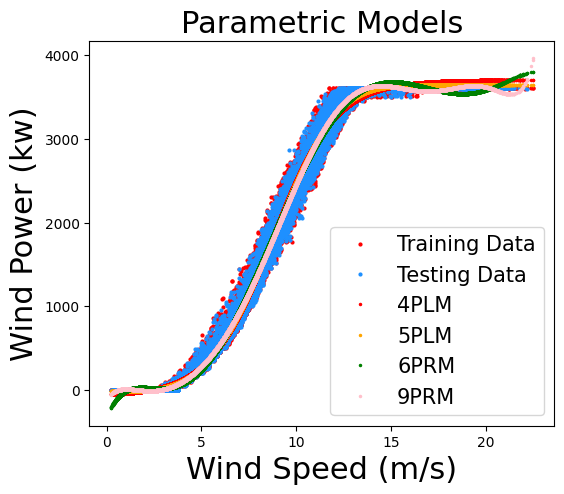

In [6]:
# PARAMETRIC MODELS

from numpy import array
from scipy.optimize import leastsq
import matplotlib.pyplot as plt

i, o, X_train, X_test, y_train, y_test = Definedata()
x = i.reshape(-1)
y = o

def func1(params1, x, y):
    a, b, c, d = params1[0], params1[1], params1[2], params1[3]
    #print(a, b, c, d)
    residual = y-(a*((1+b*np.exp(-x/c))/(1+d*np.exp(-x/c))))
    return residual

def func2(params2, x, y):
    a, b, c, d, e = params2[0], params2[1], params2[2], params2[3], params2[4]
    # print(a, b, c, d, e)
    residual2 = y-(a + (b-a)/(( 1 + (x/c)**(d) )**(e)))
    return residual2

def func3(params3, x, y):
    a, b, c, d, e, f, g = params3[0], params3[1], params3[2], params3[3], params3[4], params3[5], params3[6]
    residual = y-(a+ (b*x)+ (c*(x**2)) + (d*(x**3)) + (e*(x**4)) + (f*(x**5)) + (g*(x**6)) )
    return residual

def func4(params4, x, y):
    a, b, c, d, e, f, g, h, i, j = params4[0], params4[1], params4[2], params4[3], params4[4], params4[5], params4[6], params4[7], params4[8], params4[9]
    residual = y-(a+ (b*x)+ (c*(x**2)) + (d*(x**3)) + (e*(x**4)) + (f*(x**5)) + (g*(x**6)) +(h*(x**7)) + (i*(x**8)) +(j*(x**9)) )
    return residual

# params = [0, 0, 0]
params1 = [0.1, 0.5, 0.5, 0.1]
params2 = [10, 10, 10, 10, 10]
params3 = [10, 10, 10, 10, 10, 10, 10]
params4 = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


#4PLM
result = leastsq(func1, params1, (x, y))
a, b, c, d = result[0][0], result[0][1], result[0][2], result[0][3]
from time import time
start = time()
yfit1 = a*((1+b*np.exp(-x/c))/(1+d*np.exp(-x/c)))
print("\n \n \n This Model took %.4f seconds for training" % ((time() - start)))


print("\t\tError Table for 4PLM")
print('Mean Absolute Error      : ', metrics.mean_absolute_error(y, yfit1))
print('Mean Squared  Error      : ', metrics.mean_squared_error(y, yfit1))
print('Root Mean Squared  Error : ', np.sqrt(metrics.mean_squared_error(y, yfit1)))
r_square = metrics.r2_score(y, yfit1)
print('R-Square Error :', r_square)

print('Final Parameters ', a, b, c, d)

#############################################################################################
#5PLM
result2 = leastsq(func2, params2, (x, y))
a, b, c, d, e = result2[0][0], result2[0][1], result2[0][2], result2[0][3], result2[0][4]
start = time()
yfit2 = a + (b-a)/(( 1 + (x/c)**(d) )**(e))
print("\n \n \n This Model took %.4f seconds for training" % ((time() - start)))


print("\t\tError Table for 5PLM")
print('Mean Absolute Error      : ', metrics.mean_absolute_error(y, yfit2))
print('Mean Squared  Error      : ', metrics.mean_squared_error(y, yfit2))
print('Root Mean Squared  Error : ', np.sqrt(metrics.mean_squared_error(y, yfit2)))
r_square = metrics.r2_score(y, yfit2)
print('R-Square Error :', r_square)

print('Final Parameters ', a, b, c, d, e)
#################################################################################################
# 6PRM
result3 = leastsq(func3, params3, (x, y))
a, b, c, d, e, f, g = result3[0][0], result3[0][1], result3[0][2], result3[0][3], result3[0][4], result3[0][5], result3[0][6]
start = time()
yfit3 = (a+ (b*x)+ (c*(x**2)) + (d*(x**3)) + (e*(x**4)) + (f*(x**5)) + (g*(x**6)) )
print("\n \n \n This Model took %.4f seconds for training" % ((time() - start)))

print("\t\tError Table for 6PRM")
print('Mean Absolute Error      : ', metrics.mean_absolute_error(y, yfit3))
print('Mean Squared  Error      : ', metrics.mean_squared_error(y, yfit3))
print('Root Mean Squared  Error : ', np.sqrt(metrics.mean_squared_error(y, yfit3)))
r_square = metrics.r2_score(y, yfit3)
print('R-Square Error :', r_square)

print('Final Parameters ', a, b, c, d, e, f, g)
#################################################################################################
# 9PRM
result4 = leastsq(func4, params4, (x, y))
a, b, c, d, e, f, g, h, i, j = result4[0][0], result4[0][1], result4[0][2], result4[0][3], result4[0][4], result4[0][5], result4[0][6], result4[0][7], result4[0][8], result4[0][9]
start = time()
yfit4 = (a+ (b*x)+ (c*(x**2)) + (d*(x**3)) + (e*(x**4)) + (f*(x**5)) + (g*(x**6)) +(h*(x**7)) + (i*(x**8)) +(j*(x**9)) )
print("\n \n \n This Model took %.4f seconds for training" % ((time() - start)))

print("\t\tError Table for 9PRM")
print('Mean Absolute Error      : ', metrics.mean_absolute_error(y, yfit4))
print('Mean Squared  Error      : ', metrics.mean_squared_error(y, yfit4))
print('Root Mean Squared  Error : ', np.sqrt(metrics.mean_squared_error(y, yfit4)))
r_square = metrics.r2_score(y, yfit4)
print('R-Square Error :', r_square)

print('Final Parameters ', a, b, c, d, e, f, g, h, i, j)


plt.figure(figsize=(6,5))
# plt.plot(x, y, '.',label = 'Real Power')
X, y, X_train, X_test, y_train, y_test = Definedata()
plt.plot(X_train, y_train, '.', color="red", label='Training Data'  ,  markersize = 4)
plt.plot(X_test, y_test, '.',  color="dodgerblue", label='Testing Data'  ,  markersize =4)

plt.plot(x, yfit1,'.', color="red", label = '4PLM',  markersize=3)
plt.plot(x, yfit2,'.', color="orange", label='5PLM',  markersize=3)
plt.plot(x, yfit3,'.', color="green", label='6PRM',  markersize=3)
plt.plot(x, yfit4,'.', color="pink", label='9PRM',  markersize=3)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.xlabel('Wind Speed (m/s)', size=22)
plt.ylabel('Wind Power (kw)', size=22)
plt.title('Parametric Models',fontsize=22)
plt.legend(fontsize=15)
#plt.grid(True)
plt.show()



This Model took 0.0241 seconds for training

 Skewness value E is:    [-0.47682507]

 kurtosis value E is:    [3.76865087]


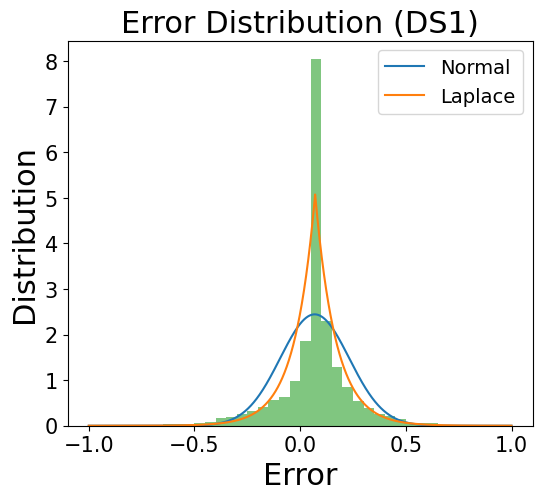

		Error Table
Mean Absolute Error      :  57.04659332800954
Mean Squared  Error      :  8932.087427375365
Root Mean Squared  Error :  94.50972133794156
Accuracy on Training set   :  0.9953928520091451
Accuracy on Testing set  :  0.9952411757853074
R-Square Error : 0.9952411757853074


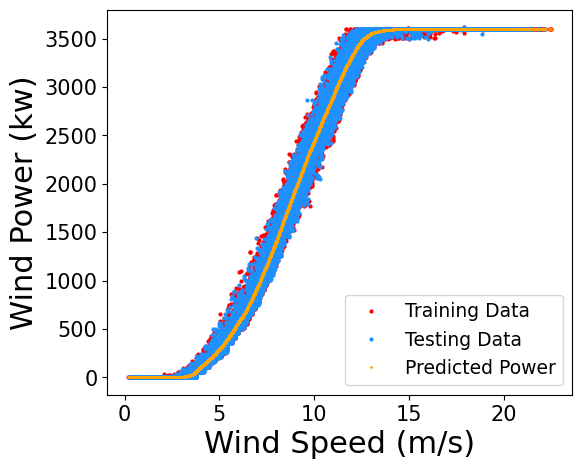

In [8]:
#  KNN
y_predicted, y_actual = Models(KNeighborsRegressor(n_neighbors=900, leaf_size= 38, p=5))
Graph_prediction(y_actual, y_predicted)

# #       OPTIMIZING KNN

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.metrics import make_scorer
# # report scikit-optimize version number
# !pip install scikit-optimize
# import skopt
# from skopt import BayesSearchCV
# import numpy as np


# n_neighbors_range = np.arange(1,20,1)
# leaf_size_range = np.arange(1,100,1)
# p_range = np.arange(1,5,1)

# print("Tuning hyper-parameters")
# param_grid = dict(n_neighbors=n_neighbors_range, leaf_size=leaf_size_range , p = p_range)

# X, y, X_train, X_test, y_train, y_test = Definedata()

# modelo=KNeighborsRegressor()

# scorer = make_scorer(mean_squared_error, greater_is_better=False)
# grid = BayesSearchCV(estimator=modelo, search_spaces=param_grid, cv=5,  scoring=scorer)

# grid.fit(X_train,y_train)

# # Checking the score for all parameters
# print("Grid scores on training set:")
# means = grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))


# print("The best parameters are %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))

In [ ]:
#Artificial Neural Network
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

step=10
for x in range(250, 365, step):
 print("\n\nANN with two H-layer and no of neurons in each: .....",x,x )
 y_predicted, y_actual = Models(MLPRegressor(hidden_layer_sizes= (x,x), max_iter=1000))
 Graph_prediction(y_actual, y_predicted)


This Model took 118.4556 seconds for training

 Skewness value E is:    [-0.54922762]

 kurtosis value E is:    [3.93651023]


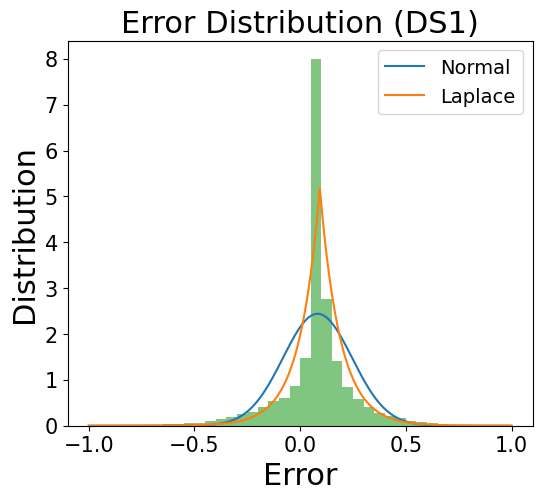

		Error Table
Mean Absolute Error      :  56.1177484914036
Mean Squared  Error      :  9057.183013952583
Root Mean Squared  Error :  95.16923354715315
Accuracy on Training set   :  0.9953279887902601
Accuracy on Testing set  :  0.9951745275453081
R-Square Error : 0.9951745275453081


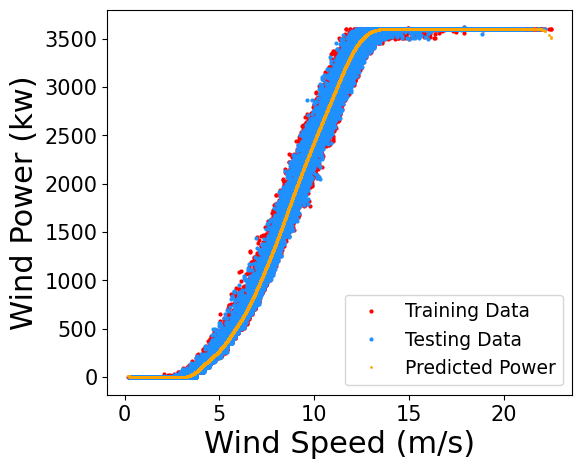

In [16]:
from sklearn import svm
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

y_predicted, y_actual = Models(svm.SVR(kernel='rbf',  C=300, gamma=0.5))
Graph_prediction(y_actual, y_predicted)

# #         optimizing SVM

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.metrics import make_scorer
# # report scikit-optimize version number
# !pip install scikit-optimize
# import skopt
# from skopt import BayesSearchCV
# import numpy as np
# from sklearn import svm
# from sklearn.svm import SVR


# gamma_range = [0.1, 0.5, 1]
# C_range = [100,200,300]
# param_grid = dict(gamma=gamma_range, C=C_range )

# print("Tuning hyper-parameters")
# modelo=svm.SVR(kernel='rbf')


# scorer = make_scorer(mean_squared_error, greater_is_better=False)
# grid = BayesSearchCV(estimator=modelo, search_spaces=param_grid, cv=2,  scoring=scorer)

# X, y, X_train, X_test, y_train, y_test = Definedata()


# grid.fit(X_train,y_train)

# # Checking the score for all parameters
# print("Grid scores on training set:")
# means = grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))


# print("The best parameters are %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))

This Model took 0.0364 seconds for training

 Skewness value E is:    [-0.45184234]

 kurtosis value E is:    [3.76622079]


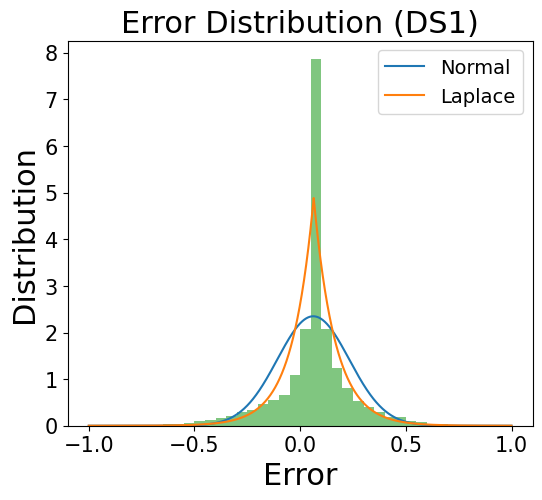

		Error Table
Mean Absolute Error      :  57.360616424275214
Mean Squared  Error      :  9040.571879410365
Root Mean Squared  Error :  95.08192193792868
Accuracy on Training set   :  0.9954637347616906
Accuracy on Testing set  :  0.995183377600789
R-Square Error : 0.995183377600789


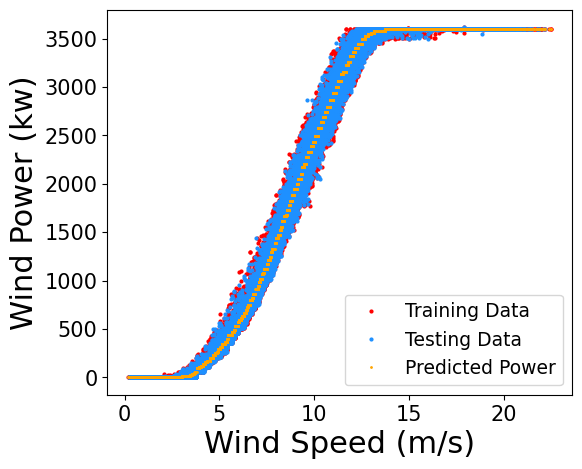

In [17]:
from sklearn.tree import DecisionTreeRegressor
y_predicted, y_actual = Models(DecisionTreeRegressor(max_depth=397, min_samples_split=7,
                                                     max_leaf_nodes=97, min_samples_leaf=162))
Graph_prediction(y_actual, y_predicted)

# #       OPTIMIZING DECISION TREES
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.metrics import make_scorer
# # report scikit-optimize version number
# !pip install scikit-optimize
# import skopt
# from skopt import BayesSearchCV
# import numpy as np



# min_samples_split_range = np.arange(2,50,5)
# max_depth_range = np.arange(2,500,5)
# min_samples_leaf_range = np.arange(2,500,5)
# max_leaf_nodes_range = np.arange(2,500,5)

# print("Tuning hyper-parameters")
# param_grid = dict(min_samples_split=min_samples_split_range, max_depth=max_depth_range,
#                   min_samples_leaf=min_samples_leaf_range , max_leaf_nodes=max_leaf_nodes_range )

# X, y, X_train, X_test, y_train, y_test = Definedata()

# modelo=DecisionTreeRegressor()

# scorer = make_scorer(mean_squared_error, greater_is_better=False)
# grid = BayesSearchCV(estimator=modelo, search_spaces=param_grid, cv=5,  scoring=scorer)

# grid.fit(X_train,y_train)

# # Checking the score for all parameters
# print("Grid scores on training set:")
# means = grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))


# print("The best parameters are %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))

This Model took 1.3151 seconds for training

 Skewness value E is:    [-0.45247447]

 kurtosis value E is:    [3.77780894]


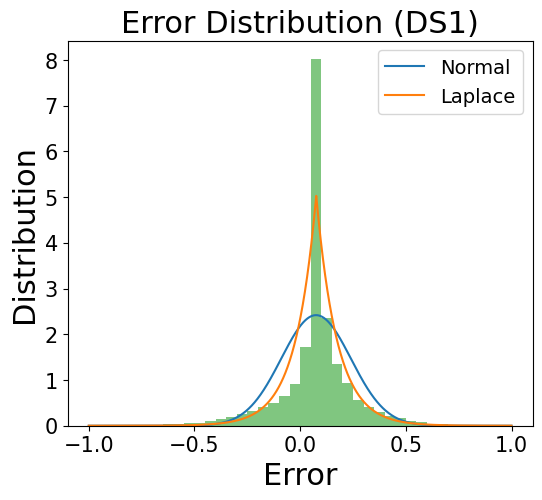

		Error Table
Mean Absolute Error      :  57.04388884646069
Mean Squared  Error      :  8950.115653929372
Root Mean Squared  Error :  94.60505089015793
Accuracy on Training set   :  0.9954834859884089
Accuracy on Testing set  :  0.9952315707336584
R-Square Error : 0.9952315707336584


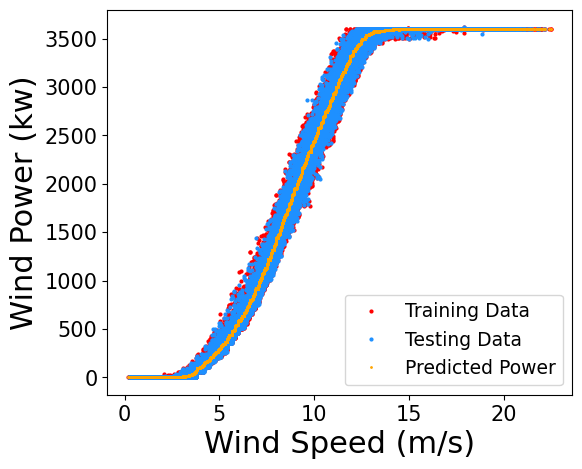

In [18]:
y_predicted, y_actual = Models(RandomForestRegressor(n_estimators=51, min_samples_split=47, min_samples_leaf=92,
                                                     max_depth=52, max_leaf_nodes=800 ))
Graph_prediction(y_actual, y_predicted)


# #       OPTIMIZING RANDOM FOREST

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.metrics import make_scorer
# # report scikit-optimize version number
# !pip install scikit-optimize
# import skopt
# from skopt import BayesSearchCV
# import numpy as np


# n_estimators_range = np.arange(1,500,10)
# min_samples_split_range = np.arange(2,50,5)
# max_depth_range = np.arange(2,505,10)
# min_samples_leaf_range = np.arange(2,500,10)
# max_leaf_nodes_range = np.arange(1,1000,50)

# print("Tuning hyper-parameters")
# param_grid = dict(n_estimators=n_estimators_range,  min_samples_split=min_samples_split_range,
#                   max_depth=max_depth_range, min_samples_leaf=min_samples_leaf_range ,
#                   max_leaf_nodes=max_leaf_nodes_range )


# X, y, X_train, X_test, y_train, y_test = Definedata()


# modelo=RandomForestRegressor()

# scorer = make_scorer(mean_squared_error, greater_is_better=False)
# grid = BayesSearchCV(estimator=modelo, search_spaces=param_grid, cv=5,  scoring=scorer)

# grid.fit(X_train,y_train)

# # Checking the score for all parameters
# print("Grid scores on training set:")
# means = grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))


# print("The best parameters are %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))

This Model took 17.4300 seconds for training

 Skewness value E is:    [-0.45039554]

 kurtosis value E is:    [3.79753929]


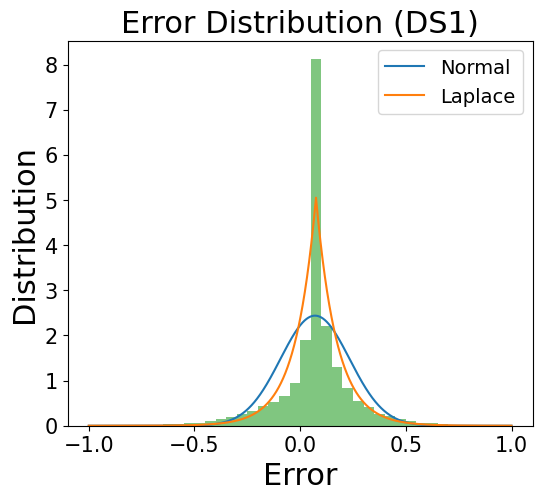

		Error Table
Mean Absolute Error      :  57.38938123133389
Mean Squared  Error      :  8931.74368332165
Root Mean Squared  Error :  94.50790275591586
Accuracy on Training set   :  0.9954357895496397
Accuracy on Testing set  :  0.9952413589247515
R-Square Error : 0.9952413589247515


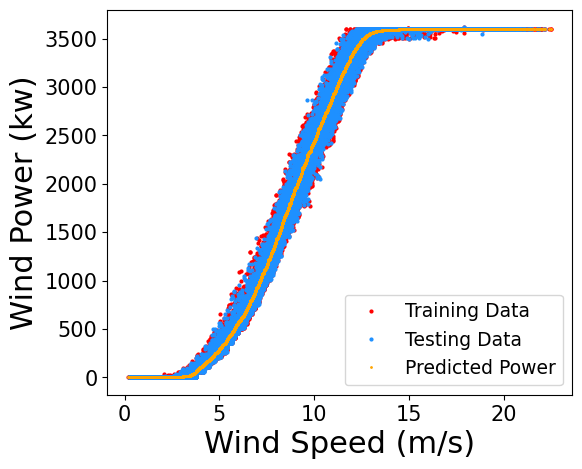

In [19]:
y_predicted, y_actual = Models(ExtraTreesRegressor(n_estimators=2800, min_samples_split=2, min_samples_leaf=1,
                                                     max_depth=500, max_leaf_nodes=95))
Graph_prediction(y_actual, y_predicted)


# #       OPTIMIZING EXTRA TREE

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.metrics import make_scorer
# # report scikit-optimize version number
# !pip install scikit-optimize
# import skopt
# from skopt import BayesSearchCV
# import numpy as np


# n_estimators_range = np.arange(400,510,5)
# min_samples_split_range = np.arange(20,60,5)
# max_depth_range = np.arange(100,200,10)
# min_samples_leaf_range = np.arange(50,100,5)
# max_leaf_nodes_range = np.arange(850,950,10)

# print("Tuning hyper-parameters")
# param_grid = dict(n_estimators=n_estimators_range,  min_samples_split=min_samples_split_range,
#                   max_depth=max_depth_range, min_samples_leaf=min_samples_leaf_range ,
#                   max_leaf_nodes=max_leaf_nodes_range )



# X, y, X_train, X_test, y_train, y_test = Definedata()

# modelo=ExtraTreesRegressor()

# scorer = make_scorer(mean_squared_error, greater_is_better=False)
# grid = BayesSearchCV(estimator=modelo, search_spaces=param_grid, cv=5,  scoring=scorer)

# grid.fit(X_train,y_train)

# # Checking the score for all parameters
# print("Grid scores on training set:")
# means = grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))


# print("The best parameters are %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))

This Model took 4.2406 seconds for training

 Skewness value E is:    [-0.46050361]

 kurtosis value E is:    [3.7919928]


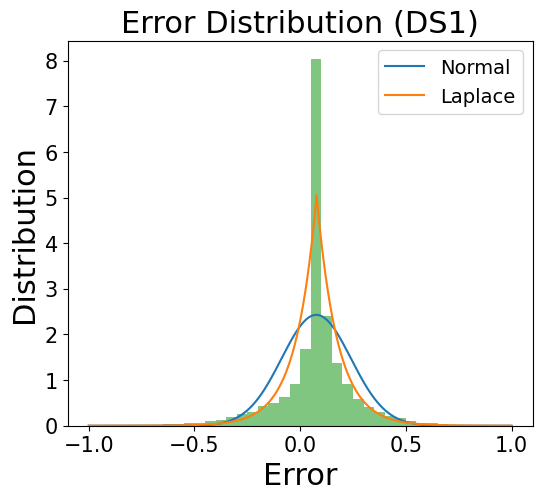

		Error Table
Mean Absolute Error      :  57.11663832783574
Mean Squared  Error      :  8959.076344596258
Root Mean Squared  Error :  94.65239745825913
Accuracy on Training set   :  0.9955172864224563
Accuracy on Testing set  :  0.9952267966702525
R-Square Error : 0.9952267966702525


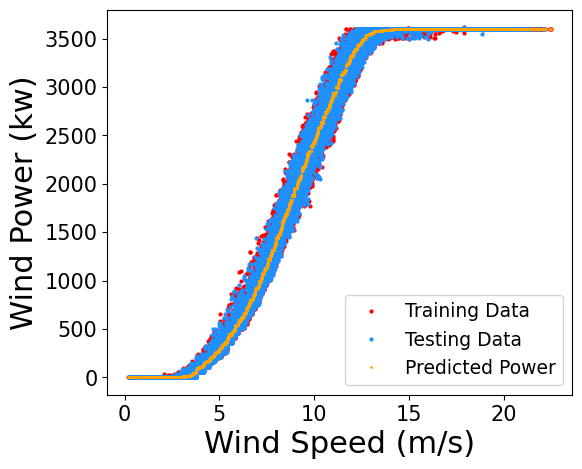

In [20]:
y_predicted, y_actual = Models(GradientBoostingRegressor(learning_rate=0.099, n_estimators=100,
                                  max_depth = 10,
                                  min_samples_split = 20,
                                  min_samples_leaf = 451,
                                  max_leaf_nodes =  77))
Graph_prediction(y_actual, y_predicted)


# #       OPTIMIZING Gradient Boost

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.metrics import make_scorer
# # report scikit-optimize version number
# !pip install scikit-optimize
# import skopt
# from skopt import BayesSearchCV
# import numpy as np


# n_estimators_range = np.arange(100,1500,50)
# max_depth_range = np.arange(10,25,2)
# min_samples_split_range = np.arange(20,40,4)
# min_samples_leaf_range = [451]
# max_leaf_nodes_range = [77]
# learning_rate_range = np.arange(0.01,1,0.03)

# print("Tuning hyper-parameters")
# param_grid = dict(
#                   n_estimators = n_estimators_range,
#                   min_samples_split = min_samples_split_range,
#                   max_depth = max_depth_range,
#                   min_samples_leaf = min_samples_leaf_range ,
#                   max_leaf_nodes = max_leaf_nodes_range ,
#                   learning_rate = learning_rate_range
#                       )


# X, y, X_train, X_test, y_train, y_test = Definedata()

# modelo=GradientBoostingRegressor()

# scorer = make_scorer(mean_squared_error, greater_is_better=False)
# grid = BayesSearchCV(estimator=modelo, search_spaces=param_grid, cv=5,  scoring=scorer)

# grid.fit(X_train,y_train)

# # Checking the score for all parameters
# print("Grid scores on training set:")
# means = grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))


# print("The best parameters are %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))